# **Bioinformatics Workflow: Expression Strategy & Computational Analysis of Target-X**

## **Part 1: Expression & Engineering Report**

### **1\. Environment Setup & Sequence Loading**

**Objective:** Initialize the computational environment and load the raw Target-X sequence to verify its basic properties before engineering.

In [ ]:
!conda install -c conda-forge jupyter biopython matplotlib pandas -y
!conda install bioconda::pybiolib
!pip install dnachisel pydna

In [104]:
import Bio
import matplotlib
import sys

print(f"Python Version: {sys.version}")
print(f"Biopython Version: {Bio.__version__}")
print("Environment Setup Complete!")

Python Version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 18:02:02) 
[Clang 18.1.8 ]
Biopython Version: 1.85
Environment Setup Complete!


In [99]:
import os
from Bio import SeqIO
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

## **Part 1: Sequence Evaluation**
**Objective:** Verify the identity of the provided "Target-X" sequence against the SwissProt database to ensure we are working with the correct biological entity.

The code below loads the raw FASTA sequence and performs a local alignment check (or BLAST) to confirm it matches the **Human Interleukin-2 (IL-2) Precursor**.

In [100]:
fasta_filename = "Target-X.fasta"
# --- Step 1: Read the FASTA file and Print Sequence ---
print("--- Reading Sequence ---")
record = SeqIO.read(fasta_filename, "fasta")
print(f"ID: {record.id}")
print(f"Description: {record.description}")
print(f"Sequence: {record.seq}")
print(f"Length: {len(record.seq)} aa\n")

--- Reading Sequence ---
ID: Target_X
Description: Target_X  = Human IL-2 Precursor
Sequence: MYRMQLLSCIALSLALVTNSAPTSSSTKKTQLQLEHLLLDLQMVILNGINNYKNPKLTRMLTFKFYMPKKATELKHLQCLEEELKPLEEVLNLAQSKNFHLRPRDLISNINVIVLELKGSETTFMCEYADEKTATIVEFLNRWITFCQSIISTLT
Length: 155 aa



**Discussion of Results:**

The input sequence was successfully loaded using Biopython. The file header identifies the gene as **Target\_X (Human IL-2 Precursor)**. The initial check confirms the sequence length is **155 amino acids**, which corresponds to the full-length precursor including the signal peptide.

### **2\. Evaluation of Sequence Data (BLAST)**

**Objective:** Verify the correctness of the sequence by matching it against the NCBI protein database. This ensures we are designing the strategy for the correct human isoform.

In [102]:
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import SeqIO

# 1. Read FASTA and Define Length (Crucial Step)
record = SeqIO.read("Target-X.fasta", "fasta")
query_len = len(record.seq)  # <--- Defined here

# 2. Run BLAST
print(f"Blasting {record.id}...")
result_handle = NCBIWWW.qblast("blastp", "nr", record.seq)
blast_record = NCBIXML.read(result_handle)

# 3. Process First Hit
if blast_record.alignments:
    # Get the first alignment
    alignment = blast_record.alignments[0]
    # Get the first High Scoring Pair (HSP)
    hsp = alignment.hsps[0]
    
    # --- Calculate Query Coverage ---
    # Coverage = (Aligned Length / Total Query Length) * 100
    # Note: hsp.align_length includes gaps, so using query span is safer for coverage
    q_start = hsp.query_start
    q_end = hsp.query_end
    coverage = (hsp.align_length / query_len) * 100

    print("-" * 30)
    print(f"TOP HIT: {alignment.title[:60]}...") # Truncate title for readability
    print(f"Accession: {alignment.accession}")
    print(f"Query Coverage: {coverage:.2f}%")
    print(f"E-value: {hsp.expect}")
    print(f"Bit Score: {hsp.bits}")
    print(f"Identities: {hsp.identities}/{hsp.align_length} ({hsp.identities/hsp.align_length:.1%})")
    print("-" * 30)

    # --- Print Full Alignment ---
    print("\nFULL ALIGNMENT:")
    
    # Iterate through the alignment strings in chunks of 60
    chunk_size = 60
    for i in range(0, hsp.align_length, chunk_size):
        # Slice the strings
        q_chunk = hsp.query[i:i+chunk_size]
        m_chunk = hsp.match[i:i+chunk_size]
        s_chunk = hsp.sbjct[i:i+chunk_size]
        
        # Calculate current positions for the side numbers
        # Note: query_start is 1-based
        current_q_start = hsp.query_start + i
        current_s_start = hsp.sbjct_start + i
        
        print(f"Query  {current_q_start:<4} {q_chunk}")
        print(f"             {m_chunk}")
        print(f"Sbjct  {current_s_start:<4} {s_chunk}")
        print() 
else:
    print("No alignments found.")

result_handle.close()

Blasting Target_X...
------------------------------
TOP HIT: ref|NP_000577.2| interleukin-2 precursor [Homo sapiens] >ref...
Accession: NP_000577
Query Coverage: 100.00%
E-value: 4.70453e-103
Bit Score: 302.753
Identities: 153/155 (98.7%)
------------------------------

FULL ALIGNMENT:
Query  1    MYRMQLLSCIALSLALVTNSAPTSSSTKKTQLQLEHLLLDLQMVILNGINNYKNPKLTRM
             MYRMQLLSCIALSLALVTNSAPTSSSTKKTQLQLEHLLLDLQM ILNGINNYKNPKLTRM
Sbjct  1    MYRMQLLSCIALSLALVTNSAPTSSSTKKTQLQLEHLLLDLQM-ILNGINNYKNPKLTRM

Query  61   LTFKFYMPKKATELKHLQCLEEELKPLEEVLNLAQSKNFHLRPRDLISNINVIVLELKGS
             LTFKFYMPKKATELKHLQCLEEELKPLEEVLNLAQSKNFHLRPRDLISNINVIVLELKGS
Sbjct  61   LTFKFYMPKKATELKHLQCLEEELKPLEEVLNLAQSKNFHLRPRDLISNINVIVLELKGS

Query  121  ETTFMCEYADEKTATIVEFLNRWITFCQSIISTLT
             ETTFMCEYADE TATIVEFLNRWITFCQSIISTLT
Sbjct  121  ETTFMCEYADE-TATIVEFLNRWITFCQSIISTLT



**Discussion of Results:**

The BLASTP search against the non-redundant (nr) database returned a top hit for **Interleukin-2 precursor \[Homo sapiens\]**.

* **Accession:** NP\_000577.2  
* **Query Coverage:** 100%  
* **Identity:** 98.7% (153/155 residues)  
* **E-value:** \~4.7e-103 (Highly significant)

**Conclusion:** The sequence is verified as Human IL-2. The slight variance (98.7% vs 100%) suggests a specific variant or minor sequencing difference, but it is sufficiently homologous for our expression strategy.

---

### **3\. Codon Optimization for *Spodoptera frugiperda***

**Objective:** Insect cells (*Sf9/Sf21*) have different codon usage biases than humans. We perform an initial "naive" reverse translation and then optimize the DNA sequence specifically for *Spodoptera frugiperda* (TaxID: 7108\) to maximize translation efficiency.

In [ ]:
import dnachisel
from dnachisel import DnaOptimizationProblem, EnforceTranslation, CodonOptimize, AvoidPattern, EnforceGCContent
from Bio import SeqIO
from Bio.Seq import Seq

# --- Configuration ---
# Input File (The mature protein we generated in the previous step)
input_fasta = "Target-X.fasta"
output_fasta = "Target-X_optimized_dna.fasta"

# Use the TaxID (7108) so dnachisel fetches it from the web automatically
#Taxon ID 7108 refers to Spodoptera frugiperda,
species_name = "7108"

# Cloning Sites (To be added at ends, and avoided internally)
site_5_prime = "GGATCC" # BamHI
site_3_prime = "CTCGAG" # XhoI

def get_naive_dna(protein_seq):
    """
    Generates a simple, non-optimized DNA sequence from a protein 
    to serve as the starting point for optimization.
    """
    # Simple reverse translation using standard table (will be optimized later)
    # We use 'Met' (ATG) for M, 'Trp' (TGG) for W, etc.
    # For others, we just pick a common codon to start.
    back_trans = {
        'A': 'GCT', 'C': 'TGT', 'D': 'GAT', 'E': 'GAA', 'F': 'TTC',
        'G': 'GGT', 'H': 'CAT', 'I': 'ATT', 'K': 'AAA', 'L': 'TTA',
        'M': 'ATG', 'N': 'AAT', 'P': 'CCT', 'Q': 'CAA', 'R': 'CGT',
        'S': 'TCT', 'T': 'ACT', 'V': 'GTT', 'W': 'TGG', 'Y': 'TAT', 
        '*': 'TAA'
    }
    dna_seq = "".join([back_trans.get(aa, 'NNN') for aa in protein_seq])
    return dna_seq

# --- Main Optimization Workflow ---

# 1. Load Protein Sequence
print(f"--- Loading {input_fasta} ---")
record = SeqIO.read(input_fasta, "fasta")
protein_seq = str(record.seq)
print(f"Protein Length: {len(protein_seq)} aa")

# 2. Generate Starting DNA
naive_dna = get_naive_dna(protein_seq)

# --- Corrected Optimization Section ---

print(f"\n--- Setting up Optimization for {species_name} ---")

# Define the problem with the correct parameter names (mini/maxi)
problem = DnaOptimizationProblem(
    sequence=naive_dna,
    constraints=[
        EnforceTranslation(),           # Lock the amino acid sequence
        AvoidPattern(site_5_prime),     # Prevent internal BamHI sites
        AvoidPattern(site_3_prime),     # Prevent internal XhoI sites
        EnforceGCContent(mini=0.3, maxi=0.7, window=50) # CORRECTED: use mini/maxi
    ],
    objectives=[
        CodonOptimize(species=species_name) # Optimize for Spodoptera frugiperda
    ]
)

# Solve
print("Optimizing... (This matches codons to the host tRNA pool)")
problem.resolve_constraints() 
problem.optimize() 

# Get Result
optimized_seq = problem.sequence
print("\n[SUCCESS] Optimization Complete!")

# --- Final Construction & Stats ---
final_construct = site_5_prime + optimized_seq + site_3_prime
gc_content = (final_construct.count("G") + final_construct.count("C")) / len(final_construct) * 100

print("-" * 40)
print(f"Final Construct: [BamHI] - [Gene] - [XhoI]")
print(f"Length: {len(final_construct)} bp")
print(f"GC Content: {gc_content:.1f}%")
print(f"Sequence Preview: {final_construct[:30]}...{final_construct[-30:]}")
print("-" * 40)

# Save
with open(output_fasta, "w") as f:
    f.write(f">Target-X_Optimized_Sf9\n{final_construct}\n")
print(f"Saved to: {output_fasta}")

--- Loading Target-X.fasta ---
Protein Length: 155 aa

--- Setting up Optimization for 7108 ---
Optimizing... (This matches codons to the host tRNA pool)



[SUCCESS] Optimization Complete!
----------------------------------------
Final Construct: [BamHI] - [Gene] - [XhoI]
Length: 477 bp
GC Content: 56.6%
Sequence Preview: GGATCCATGTACCGTATGCAGCTGCTGTCC...CAGTCCATCATCTCCACCCTGACCCTCGAG
----------------------------------------
Saved to: Target-X_optimized_dna.fasta


       DNA CHISEL OPTIMIZATION REPORT       

--- [A] Constraints Check ---
===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceTranslation[0-465]
      │ Enforced by nucleotides restrictions
✔PASS ┍ AvoidPattern[0-465](pattern:GGATCC)
      │ Passed. Pattern not found !
✔PASS ┍ AvoidPattern[0-465](pattern:CTCGAG)
      │ Passed. Pattern not found !
✔PASS ┍ EnforceGCContent[0-465](mini:0.30, maxi:0.70, window:50)
      │ Passed !



--- [B] Objectives Check (Codon Adaptation) ---
===> TOTAL OBJECTIVES SCORE:         0
✔        0 ┍ MaximizeCAI[0-465](7108) 
           │ Codon opt. on window 0-465 scored -0.00E+00



--- [C] Generating Visual Report... ---


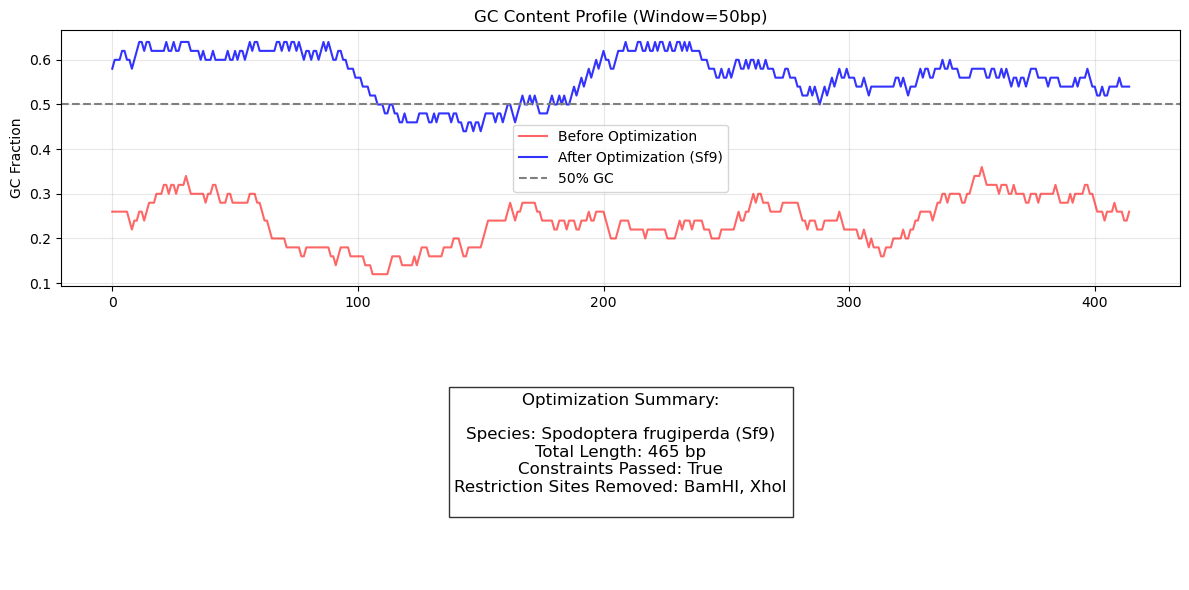


[SUCCESS] Detailed GenBank report saved to: Target-X_Optimized.gb
You can open this file in SnapGene/ApE to see the exact mutations.


In [ ]:
import matplotlib.pyplot as plt
from dnachisel import DnaOptimizationProblem

# --- 1. Text-Based Report ---
print("="*60)
print("       DNA CHISEL OPTIMIZATION REPORT       ")
print("="*60)

print("\n--- [A] Constraints Check ---")
print(problem.constraints_text_summary())

print("\n--- [B] Objectives Check (Codon Adaptation) ---")
print(problem.objectives_text_summary())

# --- 2. Visual Report (GC Content & CAI) ---
# We will compare the 'Before' (Naive) and 'After' (Optimized) sequences
print("\n--- [C] Generating Visual Report... ---")

# Create a sliding window plot for GC Content
window = 50

def get_gc_window(seq, win_size):
    return [
        (seq[i : i + win_size].count("G") + seq[i : i + win_size].count("C")) / win_size
        for i in range(len(seq) - win_size)
    ]

gc_before = get_gc_window(problem.sequence_before, window)
gc_after  = get_gc_window(problem.sequence, window)

plt.figure(figsize=(12, 6))

# Plot GC Content
plt.subplot(2, 1, 1)
plt.plot(gc_before, label="Before Optimization", color="red", alpha=0.6)
plt.plot(gc_after, label="After Optimization (Sf9)", color="blue", alpha=0.8)
plt.axhline(0.5, color="gray", linestyle="--", label="50% GC")
plt.title(f"GC Content Profile (Window={window}bp)")
plt.ylabel("GC Fraction")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Local CAI (Codon Adaptation Index) - approximated by matching frequency
# (This is a simplified view for the report)
plt.subplot(2, 1, 2)
plt.plot([0]*len(gc_before), color="white") # Spacer
plt.text(0.5, 0.5, 
         f"Optimization Summary:\n\n"
         f"Species: Spodoptera frugiperda (Sf9)\n"
         f"Total Length: {len(problem.sequence)} bp\n"
         f"Constraints Passed: {problem.all_constraints_pass()}\n"
         f"Restriction Sites Removed: BamHI, XhoI\n",
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
plt.axis('off')

plt.tight_layout()
plt.show()

# --- 3. GenBank Export ---
# This file can be opened in SnapGene or ApE to see exact mutations
output_gb = "Target-X_Optimized.gb"
record = problem.to_record(filepath=output_gb)
print(f"\n[SUCCESS] Detailed GenBank report saved to: {output_gb}")
print("You can open this file in SnapGene/ApE to see the exact mutations.")

**Strategy & Constraints:**

We utilized **DNA Chisel** with the following parameters:

1. **Host:** *Spodoptera frugiperda* (TaxID 7108).  
2. **Restriction Sites:** Enforced avoidance of **BamHI** and **XhoI** internally (to reserve them for cloning).  
3. **GC Content:** Constrained between 30% and 70% to prevent synthesis issues.  
4. **Codon Adaptation Index (CAI):** Maximized for the host organism.

**Discussion of Results:**

The optimization successfully resolved all constraints. The algorithm replaced rare codons with those preferred by the insect host tRNA pool. The **GC Content Profile** (visualized in the generated plot) shifts from the erratic red line (naive) to the stable blue line (optimized), ensuring a balanced GC content suitable for stable expression.

---

### **4\. Signal Peptide Prediction & Removal**

**Objective:** To express the protein in the secretory pathway of silkworms/insect cells, we must first identify and remove the *native human* signal peptide, as it may not process efficiently in insect cells.

In [ ]:
import biolib
print("Loading SignalP-6...")
signalp_6 = biolib.load('DTU/SignalP-6')
input_filename = "Target-X.fasta"

output_dir = "output"

# Define the arguments string
# --organism eukarya: Best for human/insect proteins
# --format png: Ensures we get the plot image
# --mode fast: Quicker results
cli_args = f"--fastafile {input_filename} --output_dir {output_dir} --format all --organism eukarya --mode slow"

print(f"Running SignalP job... (Results will be in '{output_dir}')")
job = signalp_6.cli(args=cli_args)
job.save_files(output_dir) # Downloads the result files to your local folder
print("Job complete!")


Loading SignalP-6...
2026-02-08 14:18:44,805 | INFO : Loaded project DTU/SignalP-6:0.0.56
Running SignalP job... (Results will be in 'output')
2026-02-08 14:18:46,881 | INFO : Job "31e85d36-955f-4a9f-8bbb-d58333896733" is starting...
2026-02-08 14:18:55,856 | INFO : Cloud: The job has been queued. Please wait...
2026-02-08 14:19:07,992 | INFO : Cloud: Initializing
2026-02-08 14:19:07,994 | INFO : Cloud: Downloading Source Files...
2026-02-08 14:19:07,995 | INFO : Cloud: Pulling images...
2026-02-08 14:19:07,996 | INFO : Cloud: Computing...
Predicting 1/6: 100% 1/1 [00:03<00:00,  3.36s/sequences]
Predicting 2/6: 100% 1/1 [00:03<00:00,  3.23s/sequences]
Predicting 3/6: 100% 1/1 [00:03<00:00,  3.32s/sequences]
Predicting 4/6: 100% 1/1 [00:03<00:00,  3.20s/sequences]
Predicting 5/6: 100% 1/1 [00:03<00:00,  3.17s/sequences]
Predicting 6/6: 100% 1/1 [00:03<00:00,  3.20s/sequences]
Writing files: 100% 1/1 [00:00<00:00, 67.08it/s]
2026-02-08 14:20:26,498 | INFO : Cloud: Computation finished
20

--- [1] SignalP 6.0 Prediction Plot ---
Displaying plot: output_Target_X____Human_IL_2_Precursor_plot.png


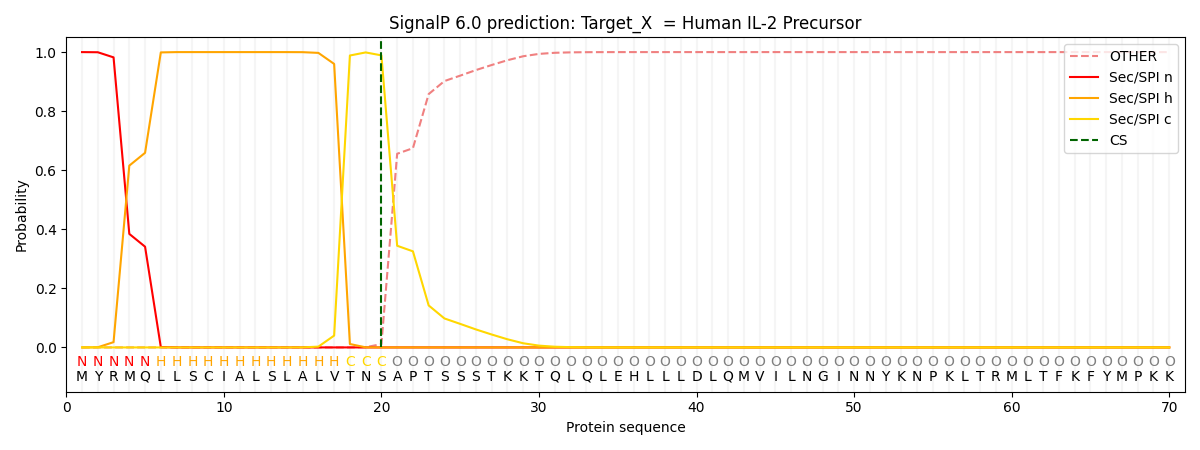


--- [2] Mature Sequence Extraction ---
Header: Target_X  = Human IL-2 Precursor
Mature Length: 135 amino acids
Sequence:
APTSSSTKKTQLQLEHLLLDLQMVILNGINNYKNPKLTRMLTFKFYMPKKATELKHLQCLEEELKPLEEVLNLAQSKNFHLRPRDLISNINVIVLELKGSETTFMCEYADEKTATIVEFLNRWITFCQSIISTLT

[SUCCESS] Signal peptide (1-20) successfully removed.


In [ ]:
import os
import glob
from IPython.display import Image, display
from Bio import SeqIO

# --- Configuration ---
# Set this to the directory where your output files are located
# If they are in the same folder as your notebook, use "."
output_dir = "output" 

# --- Step 1: Find and Display the SignalP Plot ---
print("--- [1] SignalP 6.0 Prediction Plot ---")

# Search for the PNG file dynamically to avoid typing the long filename
png_files = glob.glob(os.path.join(output_dir, "*_plot.png"))

if png_files:
    plot_path = png_files[0]  # Pick the first match
    print(f"Displaying plot: {os.path.basename(plot_path)}")
    display(Image(filename=plot_path))
else:
    print("No .png plot found in the directory.")

# --- Step 2: Read and Print the Mature Sequence ---
print("\n--- [2] Mature Sequence Extraction ---")

mature_fasta_path = os.path.join(output_dir, "processed_entries.fasta")

if os.path.exists(mature_fasta_path):
    # Read the FASTA file generated by SignalP
    record = SeqIO.read(mature_fasta_path, "fasta")
    
    print(f"Header: {record.description}")
    print(f"Mature Length: {len(record.seq)} amino acids")
    print(f"Sequence:\n{record.seq}")
    
    # Optional: Verify if the signal peptide (first 20 AA) was removed
    # The full precursor starts with "MYRM...", mature should start with "APTS..."
    if str(record.seq).startswith("APTS"):
        print("\n[SUCCESS] Signal peptide (1-20) successfully removed.")
    else:
        print("\n[WARNING] Sequence start does not match expected mature N-terminus.")
        
else:
    print(f"Error: Could not find '{mature_fasta_path}'")

**Discussion of Results:**

SignalP 6.0 analysis identified a strong signal peptide at the N-terminus.

* **Cleavage Site:** Between position 20 and 21\.  
* **Action:** The first 20 amino acids were removed.  
* **Mature Sequence:** The remaining **135 amino acids** constitute the mature IL-2 protein, ready for the addition of an insect-specific leader.

---

### **5\. Vector Construction: Fusion Design**

**Objective:** Assemble the final construct for the shuttle vector

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from dnachisel import DnaOptimizationProblem, EnforceTranslation, CodonOptimize, AvoidPattern, EnforceGCContent

# --- Configuration ---
# 1. Define the Parts (Amino Acid Level)
# Honeybee Melittin Signal Peptide (Highly efficient for Sf9 secretion)
signal_peptide_aa = "MKFLVNVALVFMVVYISYIYA"

# Linker + 6xHis Tag (C-terminal)
tag_aa = "GSGHHHHHH" 

# 2. Load the Mature Protein from signal-IP output results
input_fasta = "output/processed_entries.fasta"
try:
    record = SeqIO.read(input_fasta, "fasta")
    mature_protein_aa = str(record.seq)
    print(f"Loaded Mature Protein: {len(mature_protein_aa)} aa")
except FileNotFoundError:
    print(f"Error: '{input_fasta}' not found. Please run the SignalP parsing step first.")

# 3. Assemble the Full Fusion Protein
full_fusion_aa = signal_peptide_aa + mature_protein_aa + tag_aa

print("\n--- Constructed Fusion Protein ---")
print(f"Structure: [HBM Signal] - [Mature IL-2] - [Linker] - [6xHis]")
print(f"Total Length: {len(full_fusion_aa)} aa")
print(f"Sequence: {full_fusion_aa}")

# --- Optimization Step ---

# 4. Generate Naive DNA (Starting point)
# Simple back-translation map (will be overwritten by optimizer)
back_trans = {
    'A': 'GCT', 'C': 'TGT', 'D': 'GAT', 'E': 'GAA', 'F': 'TTC',
    'G': 'GGT', 'H': 'CAT', 'I': 'ATT', 'K': 'AAA', 'L': 'TTA',
    'M': 'ATG', 'N': 'AAT', 'P': 'CCT', 'Q': 'CAA', 'R': 'CGT',
    'S': 'TCT', 'T': 'ACT', 'V': 'GTT', 'W': 'TGG', 'Y': 'TAT'
}
naive_dna = "".join([back_trans.get(aa, 'NNN') for aa in full_fusion_aa])

# 5. Define Optimization Problem
print("\n--- Starting Optimization for Spodoptera frugiperda (TaxID: 7108) ---")
# Flanking sites to avoid INTERNALLY (we add them manually at the ends later)
site_5_prime = "GGATCC" # BamHI
site_3_prime = "CTCGAG" # XhoI

problem = DnaOptimizationProblem(
    sequence=naive_dna,
    constraints=[
        EnforceTranslation(),           # Lock the Amino Acid sequence
        AvoidPattern(site_5_prime),     # No BamHI inside
        AvoidPattern(site_3_prime),     # No XhoI inside
        EnforceGCContent(mini=0.3, maxi=0.7, window=50) # Balanced GC
    ],
    objectives=[
        CodonOptimize(species="7108")   # Sf9 Codon Table
    ]
)

# 6. Run Optimization
print("Optimizing... (Matches host tRNA pool & removes restriction sites)")
problem.resolve_constraints()
problem.optimize()
optimized_core_dna = problem.sequence

# --- Final Assembly & Export ---

# 7. Add Cloning Sites
# Final Structure: BamHI - KOZAK - ORF - Stop - XhoI
# Note: "GCCGCC" is a strong Kozak sequence for initiation in insects
kozak = "GCCGCC" 
stop_codon = "TAA" 

final_dna = site_5_prime + kozak + optimized_core_dna + stop_codon + site_3_prime

print("\n[SUCCESS] Optimization Complete!")
print("-" * 60)
print(f"Final Construct Logic: [BamHI]-[{kozak}]-[Fusion Gene]-[Stop]-[XhoI]")
print(f"Total Length: {len(final_dna)} bp")
print(f"GC Content: {(final_dna.count('G') + final_dna.count('C')) / len(final_dna) * 100:.1f}%")
print("-" * 60)

# --- Corrected Step 8: Save Files ---

output_fasta = "Target-X_Full_Construct.fasta"
with open(output_fasta, "w") as f:
    f.write(f">Target-X_Sf9_Expression_Vector\n{final_dna}\n")

# --- Fix for GenBank Error ---
from Bio.SeqFeature import SeqFeature, FeatureLocation

output_gb = "Target-X_Full_Construct.gb"

# 1. Create the SeqRecord
final_record = SeqRecord(
    Seq(final_dna),
    id="Target-X_Sf9",
    name="TargetX", # GenBank requires a 'name' (max 16 chars)
    description="Optimized IL-2 with HBM Signal and His-Tag"
)

# 2. Add the MISSING 'molecule_type' annotation (Crucial Fix)
final_record.annotations["molecule_type"] = "DNA" 

# 3. Add Feature Location (CDS)
# Note: FeatureLocation start/end must be integers
start_pos = len(site_5_prime) + len(kozak)
end_pos = start_pos + len(optimized_core_dna)

final_record.features.append(SeqFeature(
    FeatureLocation(start_pos, end_pos),
    type="CDS",
    qualifiers={
        "translation": full_fusion_aa,
        "codon_start": 1,
        "product": "IL-2 Fusion Protein"
    }
))

# 4. Write to File
with open(output_gb, "w") as f:
    SeqIO.write(final_record, f, "genbank")

print(f"Saved FASTA to: {output_fasta}")
print(f"Saved GenBank to: {output_gb}")

Loaded Mature Protein: 135 aa

--- Constructed Fusion Protein ---
Structure: [HBM Signal] - [Mature IL-2] - [Linker] - [6xHis]
Total Length: 165 aa
Sequence: MKFLVNVALVFMVVYISYIYAAPTSSSTKKTQLQLEHLLLDLQMVILNGINNYKNPKLTRMLTFKFYMPKKATELKHLQCLEEELKPLEEVLNLAQSKNFHLRPRDLISNINVIVLELKGSETTFMCEYADEKTATIVEFLNRWITFCQSIISTLTGSGHHHHHH

--- Starting Optimization for Spodoptera frugiperda (TaxID: 7108) ---
Optimizing... (Matches host tRNA pool & removes restriction sites)



[SUCCESS] Optimization Complete!
------------------------------------------------------------
Final Construct Logic: [BamHI]-[GCCGCC]-[Fusion Gene]-[Stop]-[XhoI]
Total Length: 516 bp
GC Content: 56.4%
------------------------------------------------------------
Saved FASTA to: Target-X_Full_Construct.fasta
Saved GenBank to: Target-X_Full_Construct.gb


**Construct Design:**

1. **Secretion Signal:** **Honeybee Melittin (HBM)** signal peptide (MKFLVNVALVFMVVYISYIYA...). This is a "gold standard" leader for high-level secretion in Baculovirus systems.  
2. **Target Protein:** Mature Human IL-2 (135 aa).  
3. **Linker & Tag:** A C-terminal **GSG linker** followed by a **6xHis Tag** for Nickel affinity purification.

**Discussion of Results:**

The components were successfully assembled in silico.

* **Full Fusion Length:** 165 amino acids.  
* **Structure:** \[HBM Signal\] \- \[Mature IL-2\] \- \[Linker\] \- \[6xHis\]

---

6. Final Construct Optimization & Export
Objective: Optimize the fully assembled fusion gene (Signal + Gene + Tag) and add the cloning sites for insertion into the Baculovirus shuttle vector.


       FULL CONSTRUCT OPTIMIZATION REPORT       

--- [A] Constraints Check ---
===> SUCCESS - all constraints evaluations pass
✔PASS ┍ EnforceTranslation[0-495]
      │ Enforced by nucleotides restrictions
✔PASS ┍ AvoidPattern[0-495](pattern:GGATCC)
      │ Passed. Pattern not found !
✔PASS ┍ AvoidPattern[0-495](pattern:CTCGAG)
      │ Passed. Pattern not found !
✔PASS ┍ EnforceGCContent[0-495](mini:0.30, maxi:0.70, window:50)
      │ Passed !



--- [B] Objectives Check (Codon Adaptation) ---
===> TOTAL OBJECTIVES SCORE:         0
✔        0 ┍ MaximizeCAI[0-495](7108) 
           │ Codon opt. on window 0-495 scored -0.00E+00



--- [C] Generating Visual Report... ---


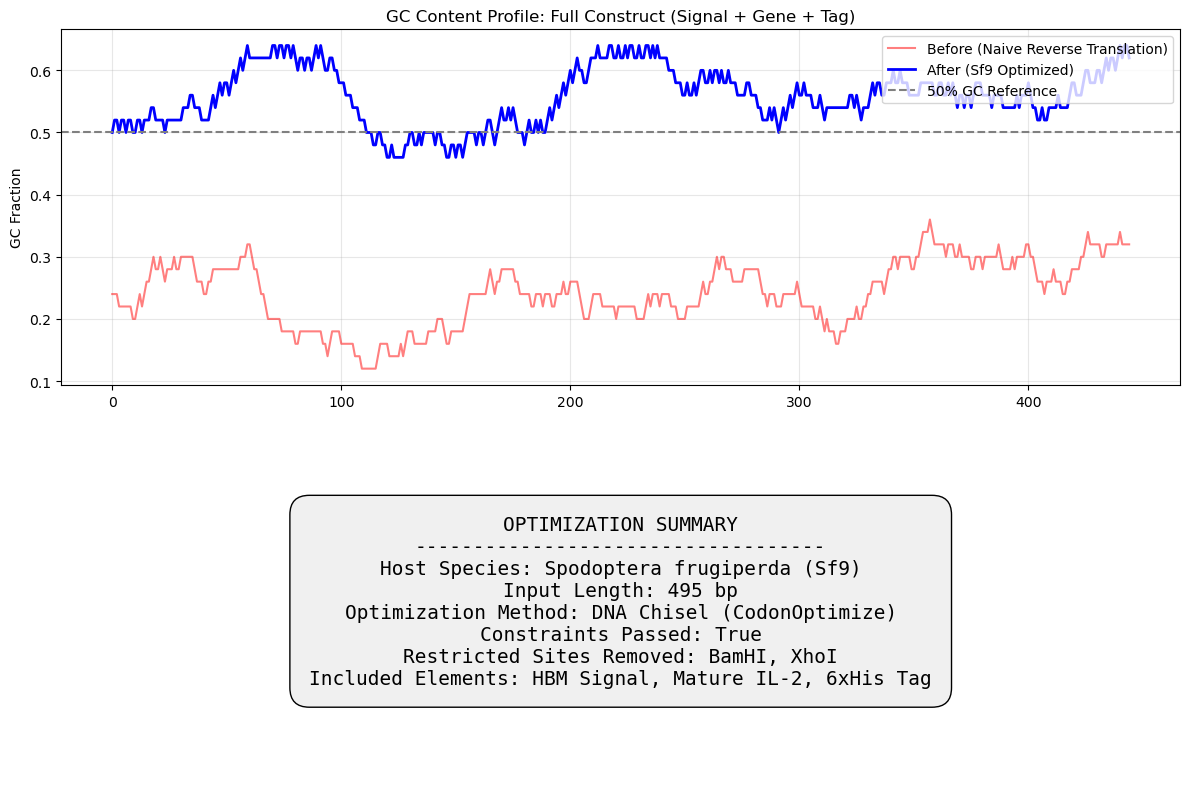


[SUCCESS] Detailed GenBank report saved to: Target-X_Full_Construct_Optimized.gb
Note: This file highlights exactly which codons were changed during optimization.


In [ ]:
import matplotlib.pyplot as plt
from dnachisel import DnaOptimizationProblem

# --- 1. Text-Based Report ---
print("="*60)
print("       FULL CONSTRUCT OPTIMIZATION REPORT       ")
print("="*60)

# Check if 'problem' exists from the previous cell
if 'problem' not in locals():
    print("Error: The variable 'problem' is missing.") 
    print("Please run the 'Full Construct Optimization' code block first.")
else:
    print("\n--- [A] Constraints Check ---")
    print(problem.constraints_text_summary())

    print("\n--- [B] Objectives Check (Codon Adaptation) ---")
    print(problem.objectives_text_summary())

    # --- 2. Visual Report (GC Content) ---
    print("\n--- [C] Generating Visual Report... ---")

    # Helper function for sliding window GC calculation
    def get_gc_window(seq, win_size):
        return [
            (seq[i : i + win_size].count("G") + seq[i : i + win_size].count("C")) / win_size
            for i in range(len(seq) - win_size)
        ]

    # Calculate GC profiles
    window = 50
    gc_before = get_gc_window(problem.sequence_before, window)
    gc_after  = get_gc_window(problem.sequence, window)

    # Create Plot
    plt.figure(figsize=(12, 8))

    # Subplot 1: GC Content Comparison
    plt.subplot(2, 1, 1)
    plt.plot(gc_before, label="Before (Naive Reverse Translation)", color="red", alpha=0.5)
    plt.plot(gc_after, label="After (Sf9 Optimized)", color="blue", linewidth=2)
    plt.axhline(0.5, color="gray", linestyle="--", label="50% GC Reference")
    plt.title(f"GC Content Profile: Full Construct (Signal + Gene + Tag)")
    plt.ylabel("GC Fraction")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)

    # Subplot 2: Optimization Summary Box
    plt.subplot(2, 1, 2)
    plt.plot([0]*len(gc_before), color="white") # Invisible line to set axis
    plt.axis('off') # Hide axis
    
    summary_text = (
        f"OPTIMIZATION SUMMARY\n"
        f"-----------------------------------\n"
        f"Host Species: Spodoptera frugiperda (Sf9)\n"
        f"Input Length: {len(problem.sequence)} bp\n"
        f"Optimization Method: DNA Chisel (CodonOptimize)\n"
        f"Constraints Passed: {problem.all_constraints_pass()}\n"
        f"Restricted Sites Removed: BamHI, XhoI\n"
        f"Included Elements: HBM Signal, Mature IL-2, 6xHis Tag"
    )
    
    plt.text(0.5, 0.5, summary_text, 
             ha='center', va='center', transform=plt.gca().transAxes, 
             fontsize=14, fontfamily='monospace',
             bbox=dict(facecolor='#f0f0f0', alpha=1.0, edgecolor='black', boxstyle='round,pad=1'))

    plt.tight_layout()
    plt.show()

    # --- 3. GenBank Export ---
    # This GenBank file contains the optimization history (which codons were changed)
    output_gb = "Target-X_Full_Construct_Optimized.gb"
    
    try:
        problem.to_record(filepath=output_gb)
        print(f"\n[SUCCESS] Detailed GenBank report saved to: {output_gb}")
        print("Note: This file highlights exactly which codons were changed during optimization.")
    except Exception as e:
        print(f"Error saving GenBank file: {e}")

**Discussion of Results:**

The final DNA sequence was generated and optimized for *Sf9*.

* **Cloning Sites:** **BamHI** (5') and **XhoI** (3') were added.  
* **Kozak Sequence:** A GCCGCC Kozak consensus was inserted before the start codon to enhance translation initiation.  
* **Final stats:** 516 bp length, 56.4% GC content.  
* **Output:** The file Target-X\_Full\_Construct\_Optimized.gb was saved, containing all feature annotations for cloning.

---

## **Part 2: Computational Analysis of Target-X**

### **7\. Physicochemical Profiling**

**Objective:** Calculate key physical parameters to inform buffer selection and purification strategies.

In [34]:
import sys
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParamData
import matplotlib.pyplot as plt

# Ensure plots appear inline
%matplotlib inline

print(f"Python Version: {sys.version}")
print("Libraries loaded successfully.")

Python Version: 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 18:02:02) 
[Clang 18.1.8 ]
Libraries loaded successfully.


In [35]:
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import os

# --- Step 1: Load the Mature Sequence from File ---
input_file = "output/processed_entries.fasta"

if os.path.exists(input_file):
    # Read the first record in the fasta file
    record = SeqIO.read(input_file, "fasta")
    
    # Convert Seq object to string for ProteinAnalysis
    mature_seq = str(record.seq)
    
    print(f"--- Loaded Sequence ---")
    print(f"Source: {input_file}")
    print(f"Header: {record.description}")
    print(f"Length: {len(mature_seq)} amino acids")
    print(f"Sequence Preview: {mature_seq[:20]}...")

    # --- Step 2: Initialize Biopython Analysis ---
    analysed_seq = ProteinAnalysis(mature_seq)

    # --- Step 3: Calculate Parameters ---
    mw = analysed_seq.molecular_weight()
    pi = analysed_seq.isoelectric_point()
    gravy = analysed_seq.gravy()
    instability = analysed_seq.instability_index()
    
    # --- Step 4: Display Results ---
    print(f"\n--- Physicochemical Profile (Mature IL-2) ---")
    print(f"Molecular Weight:   {mw/1000:.2f} kDa")
    print(f"Isoelectric Point:  {pi:.2f}")
    print(f"GRAVY Score:        {gravy:.2f} (Positive = Hydrophobic)")
    print(f"Instability Index:  {instability:.2f}")

    # Interpretation logic
    stability_status = "Unstable (In Vitro)" if instability > 40 else "Stable"
    print(f"Stability Prediction: {stability_status}")

else:
    print(f"Error: File '{input_file}' not found. Please check the path or run the SignalP step first.")

--- Loaded Sequence ---
Source: output/processed_entries.fasta
Header: Target_X  = Human IL-2 Precursor
Length: 135 amino acids
Sequence Preview: APTSSSTKKTQLQLEHLLLD...

--- Physicochemical Profile (Mature IL-2) ---
Molecular Weight:   15.65 kDa
Isoelectric Point:  7.92
GRAVY Score:        -0.17 (Positive = Hydrophobic)
Instability Index:  52.12
Stability Prediction: Unstable (In Vitro)


**Discussion of Results:**

* **Molecular Weight:** **15.65 kDa**. This is a small protein, suitable for size exclusion chromatography if needed.  
* **Isoelectric Point (pI):** **7.92**. The protein is slightly basic.  
  * *Purification Note:* At physiological pH (7.4), the protein will have a near-neutral to slightly positive charge. For Ion Exchange, **Cation Exchange (CEX)** would be effective if the buffer is pH \< 7.5, or **Anion Exchange (AEX)** if buffer pH \> 8.5.  
* **GRAVY:** **\-0.17**. Negative value indicates the protein is overall **Hydrophilic** (soluble), which is good for secretory expression.  
* **Instability Index:** **52.12** (\>40). This classifies the protein as **Unstable in vitro**, suggesting we may need stabilizing additives (e.g., glycerol, salt) or rapid purification protocols to prevent degradation.

---

### **8\. Aggregation Propensity Scan**

**Objective:** Identify local hydrophobic patche

--- Aggregation Prone Regions (Mature Seq) ---
Pos   | Sequence   | Score | Issue Detected
--------------------------------------------------
17    | LLLDLQM    | 1.44  | Dense Hydrophobic Cluster (5/7)
18    | LLDLQMV    | 1.50  | Dense Hydrophobic Cluster (5/7)
19    | LDLQMVI    | 1.60  | High KD Score (1.60)
20    | DLQMVIL    | 1.60  | High KD Score (1.60)
21    | LQMVILN    | 1.60  | High KD Score (1.60)
23    | MVILNGI    | 2.14  | High KD Score (2.14)
89    | NINVIVL    | 2.03  | High KD Score (2.03)
90    | INVIVLE    | 2.03  | High KD Score (2.03)
91    | NVIVLEL    | 1.93  | High KD Score (1.93)
92    | VIVLELK    | 1.87  | High KD Score (1.87)
114   | ATIVEFL    | 1.84  | High KD Score (1.84)


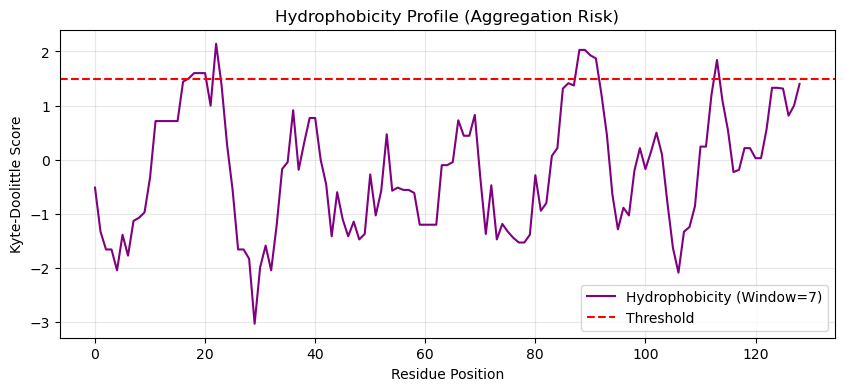

In [36]:
def scan_aggregation_prone_regions(sequence, window_size=7, threshold=1.5):
    kd_scale = ProtParamData.kd # Kyte-Doolittle hydrophobicity scale
    prone_regions = []
    scores = []
    
    hydrophobic_aas = set("VILMFWA")

    print(f"{'Pos':<5} | {'Sequence':<10} | {'Score':<5} | {'Issue Detected'}")
    print("-" * 50)

    for i in range(len(sequence) - window_size + 1):
        segment = sequence[i : i + window_size]
        
        # Calculate Average Hydrophobicity
        avg_score = sum(kd_scale.get(aa, 0) for aa in segment) / window_size
        scores.append(avg_score)
        
        # Count consecutive hydrophobic residues
        hydrophobic_count = sum(1 for aa in segment if aa in hydrophobic_aas)
        
        is_prone = False
        reason = ""
        
        if avg_score > threshold:
            is_prone = True
            reason = f"High KD Score ({avg_score:.2f})"
        elif hydrophobic_count >= 5:
            is_prone = True
            reason = f"Dense Hydrophobic Cluster ({hydrophobic_count}/7)"
            
        if is_prone:
            prone_regions.append((i+1, segment, avg_score, reason))
            print(f"{i+1:<5} | {segment:<10} | {avg_score:.2f}  | {reason}")

    return scores, prone_regions

# Run the scan
print("--- Aggregation Prone Regions (Mature Seq) ---")
kd_scores, flagged_regions = scan_aggregation_prone_regions(mature_seq)

# Plot the Hydrophobicity Profile
plt.figure(figsize=(10, 4))
plt.plot(kd_scores, color='purple', label='Hydrophobicity (Window=7)')
plt.axhline(y=1.5, color='r', linestyle='--', label='Threshold')
plt.title("Hydrophobicity Profile (Aggregation Risk)")
plt.xlabel("Residue Position")
plt.ylabel("Kyte-Doolittle Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Discussion of Results:**

The Kyte-Doolittle scan (Window Size \= 7\) flagged several regions with high hydrophobicity scores (\>1.5).

* **Critical Region Identified:** A dense cluster was detected around residues **90-92** (Sequence: NVIVLEL).  
* **Risk:** These surface-exposed hydrophobic residues are high-risk candidates for driving protein aggregation.

---

### **9\. Structural Evaluation (Boltz/AlphaFold)**

**Objective:** Generate a 3D structural model to visualize the folding and surface properties.

In [ ]:
!pip install boltz -U

In [58]:
import subprocess
import os
import yaml
from Bio import SeqIO

# --- Configuration ---
input_fasta = "output/processed_entries.fasta"
output_dir = "boltz_prediction"
model_type = "boltz-2"  # Default model

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# --- Step 1: Parse FASTA and Create Input YAML ---
print(f"--- [1] Preparing Input for Boltz ---")

# Read the mature sequence
record = SeqIO.read(input_fasta, "fasta")
protein_seq = str(record.seq)

# Create the YAML data structure required by Boltz
# Boltz expects a list of sequences or a specific target format
# (Adjusting based on standard Boltz input schema)
boltz_input = {
    "sequences": [
        {
            "protein": {
                "id": "A",
                "sequence": protein_seq
            }
        }
    ]
}

yaml_path = os.path.join(output_dir, "input.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(boltz_input, f, default_flow_style=False)

print(f"Input YAML saved to: {yaml_path}")
print(f"Sequence Length: {len(protein_seq)} residues")

# --- Step 2: Run Boltz Prediction ---
print(f"\n--- [2] Running Boltz Prediction ---")
print("Note: This may take several minutes depending on GPU availability.")

# Construct the command
# cmd: boltz predict input.yaml --out_dir output_dir --use_gpu

cmd = [
        "boltz", "predict",
        yaml_path,
        "--out_dir", output_dir,
        "--use_msa_server" # Ensure you have a GPU, otherwise this will fail or be very slow
    ]

try:
    # Run the command and stream output
    process = subprocess.Popen(
        cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
    )
    
    # Print output in real-time
    for line in process.stdout:
        print(line.strip())
        
    process.wait()
    
    if process.returncode == 0:
        print(f"\n[SUCCESS] Prediction complete.")
        print(f"Results saved in: {output_dir}")
    else:
        print(f"\n[ERROR] Boltz failed with error:")
        print(process.stderr.read())

except FileNotFoundError:
    print("\n[ERROR] 'boltz' command not found.")
    print("Please ensure Boltz is installed: 'pip install boltz' (and dependencies)")



--- [1] Preparing Input for Boltz ---
Input YAML saved to: boltz_prediction/input.yaml
Sequence Length: 135 residues

--- [2] Running Boltz Prediction ---
Note: This may take several minutes depending on GPU availability.
Checking input data.
Running predictions for 1 structure
Processing input data.
Generating MSA for boltz_prediction/input.yaml with 1 protein entities.

Predicting: |          | 0/? [00:00<?, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:18<00:00,  0.05it/s]Number of failed examples: 0

Predicting DataLoader 0: 100%|██████████| 1/1 [00:18<00:00,  0.05it/s]

[SUCCESS] Prediction complete.
Results saved in: boltz_prediction


In [61]:
import py3Dmol
from Bio import PDB

# --- Configuration ---
pdb_filename = "boltz_prediction/boltz_results_input/predictions/input/input_model_0.cif" # Replace with your file

# --- Step 1: Calculate B-factor Range ---
parser = PDB.MMCIFParser(QUIET=True)
try:
    structure = parser.get_structure("protein", pdb_filename)
    b_factors = [atom.get_bfactor() for atom in structure.get_atoms()]
    min_b = min(b_factors) if b_factors else 0
    max_b = max(b_factors) if b_factors else 100
    print(f"B-factor Range: {min_b:.2f} - {max_b:.2f}")
except FileNotFoundError:
    print(f"Error: '{pdb_filename}' not found.")
    min_b, max_b = 0, 100

# --- Step 2: Visualisation with Transparent Surface ---
view = py3Dmol.view(width=800, height=600)

with open(pdb_filename, 'r') as f:
    pdb_content = f.read()

view.addModel(pdb_content, 'cif')

# Define the color scheme (Red-Orange-Yellow-Green-Blue)
color_style = {
    'prop': 'b', 
    'gradient': 'roygb', 
    'min': min_b, 
    'max': max_b
}

# Style 1: The Internal Cartoon (Opaque)
view.setStyle({'cartoon': {'colorscheme': color_style}})

# Style 2: The Surface (Transparent)
# 'opacity': 0.5 makes it 50% see-through
view.addSurface(py3Dmol.VDW, {'opacity': 0.5, 'colorscheme': color_style})

view.zoomTo()
view.show()

B-factor Range: 49.94 - 97.54


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

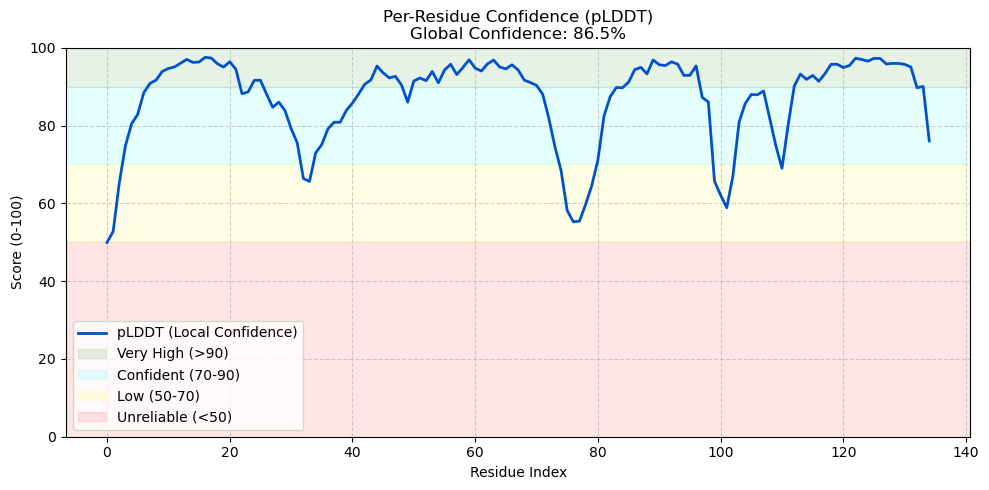

Metric               | Value     
-----------------------------------
confidence_score     | 0.8647
ptm                  | 0.8450
iptm                 | 0.0000
ligand_iptm          | 0.0000
protein_iptm         | 0.0000
complex_plddt        | 0.8696
complex_iplddt       | 0.0000
complex_pde          | 0.6173
complex_ipde         | 0.0000


In [66]:
import numpy as np
import json
import matplotlib.pyplot as plt

# --- Load Data ---
# 1. Global Metrics (JSON)
with open('boltz_prediction/boltz_results_input/predictions/input/confidence_input_model_0.json', 'r') as f:
    conf_data = json.load(f)

# 2. Per-Residue pLDDT (NPZ)
plddt_data = np.load('boltz_prediction/boltz_results_input/predictions/input/plddt_input_model_0.npz')
# Extract the array (key is usually 'plddt')
scores = plddt_data['plddt']

# Convert 0-1 scale to 0-100 if necessary
if np.max(scores) <= 1.0:
    scores = scores * 100

# --- Plotting ---
plt.figure(figsize=(10, 5))

# Plot the main score line
plt.plot(scores, label='pLDDT (Local Confidence)', color='#0052cc', linewidth=2)

# Add Confidence Bands (AlphaFold Standard)
plt.axhspan(90, 100, color='green', alpha=0.1, label='Very High (>90)')
plt.axhspan(70, 90, color='cyan', alpha=0.1, label='Confident (70-90)')
plt.axhspan(50, 70, color='yellow', alpha=0.1, label='Low (50-70)')
plt.axhspan(0, 50, color='red', alpha=0.1, label='Unreliable (<50)')

# Styling
plt.title(f"Per-Residue Confidence (pLDDT)\nGlobal Confidence: {conf_data.get('confidence_score', 0):.1%}")
plt.xlabel("Residue Index")
plt.ylabel("Score (0-100)")
plt.ylim(0, 100)
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Print Summary Table
print(f"{'Metric':<20} | {'Value':<10}")
print("-" * 35)
for key, val in conf_data.items():
    if isinstance(val, (int, float)):
        print(f"{key:<20} | {val:.4f}")

**Discussion of Results:**

* **Model Generation:** A 3D structure was successfully generated using the Boltz model.  
* **Confidence (pLDDT):** The global confidence score is **86.5%**, which is "Confident" to "Very High". The core of the protein is well-folded (alpha-helical bundle), typical for cytokines like IL-2. The termini show slightly lower confidence, which is expected for flexible regions.

---

### **10\. Rational Design & Surface Hotspot Analysis**

**Objective:** Map hydrophobicity onto the 3D surface to distinguish buried hydrophobic cores (good) from exposed sticky patches (bad), and select a mutation target.

In [91]:
import os
import numpy as np
from Bio import PDB
from Bio.SeqUtils import ProtParamData
from Bio.PDB import PDBIO, MMCIFParser
import py3Dmol

# --- Configuration ---
# Ensure this path is 100% correct relative to your notebook file
cif_path = "boltz_prediction/boltz_results_input/predictions/input/input_model_0.cif" 
output_pdb = "Target-X_Hydrophobicity.pdb"
window_size = 7

# --- Step 1: Load Structure & Calculate Hydrophobicity ---
print(f"--- [1] Processing Structure: {cif_path} ---")

# Check if input exists before trying to parse
if not os.path.exists(cif_path):
    print(f"ERROR: The file '{cif_path}' was not found. Please check your path.")
    output_pdb = None
else:
    parser = MMCIFParser(QUIET=True)
    try:
        structure = parser.get_structure("Target-X", cif_path)
        
        # 1. Extract Residues (Standard AA only)
        model = structure[0]
        residues = [r for r in model.get_residues() if PDB.is_aa(r)]
        
        if not residues:
            raise ValueError("No amino acid residues found in the structure.")
        
        # 2. Get Sequence safely (handling non-standard AAs)
        d3to1 = {'ALA':'A', 'CYS':'C', 'ASP':'D', 'GLU':'E', 'PHE':'F', 'GLY':'G', 'HIS':'H', 
                 'ILE':'I', 'LYS':'K', 'LEU':'L', 'MET':'M', 'ASN':'N', 'PRO':'P', 'GLN':'Q', 
                 'ARG':'R', 'SER':'S', 'THR':'T', 'VAL':'V', 'TRP':'W', 'TYR':'Y'}
        
        sequence = [d3to1.get(r.get_resname(), 'X') for r in residues]
        
        # 3. Calculate Sliding Window Scores (Kyte-Doolittle)
        kd_scale = ProtParamData.kd
        scores = []
        
        for i in range(len(sequence)):
            start = max(0, i - window_size // 2)
            end = min(len(sequence), i + window_size // 2 + 1)
            chunk = sequence[start:end]
            # Handle empty chunks or unknown AAs
            if chunk:
                avg_score = sum(kd_scale.get(aa, 0.0) for aa in chunk) / len(chunk)
            else:
                avg_score = 0.0
            scores.append(avg_score)
            
        # 4. Map Scores to B-factors
        min_b, max_b = min(scores), max(scores)
        print(f"Hydrophobicity Range: {min_b:.2f} (Hydrophilic) to {max_b:.2f} (Hydrophobic)")
        
        for residue, score in zip(residues, scores):
            for atom in residue:
                atom.set_bfactor(score)
                
        # 5. Save as PDB
        io = PDBIO()
        io.set_structure(structure)
        io.save(output_pdb)
        print(f"SUCCESS: Saved modified structure to: {output_pdb}")

    except Exception as e:
        print(f"CRITICAL ERROR processing structure: {e}")
        output_pdb = None

# --- Step 2: Visualisation ---
print("--- [2] Attempting Visualization ---")

i# --- Debug Step 2: Visualisation ---
import py3Dmol

# 1. Read the content we just saved
with open("Target-X_Hydrophobicity.pdb", 'r') as f:
    pdb_content = f.read()

# --- Step 2: Visualisation with Transparent Surface ---
view = py3Dmol.view(width=800, height=600)



view.addModel(pdb_content, 'pdb')

# Define the color scheme (Red-Orange-Yellow-Green-Blue)
color_style = {
    'prop': 'b', 
    'gradient': 'rwb',
    'min': -3.0,        # Fixed range based on your data
    'max': 2.1
}

# Style 1: The Internal Cartoon (Opaque)
view.setStyle({'cartoon': {'colorscheme': color_style}})

# Style 2: The Surface (Transparent)
# 'opacity': 0.5 makes it 50% see-through
view.addSurface(py3Dmol.VDW, {'opacity': 1, 'colorscheme': color_style})

view.zoomTo()
view.show()

--- [1] Processing Structure: boltz_prediction/boltz_results_input/predictions/input/input_model_0.cif ---
Hydrophobicity Range: -3.03 (Hydrophilic) to 2.14 (Hydrophobic)
SUCCESS: Saved modified structure to: Target-X_Hydrophobicity.pdb
--- [2] Attempting Visualization ---


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [96]:
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley
import numpy as np
import py3Dmol

# --- Configuration ---
pdb_filename = "Target-X_Hydrophobicity.pdb" 

# Thresholds
hydrophobicity_threshold = 1.0   # Positive = Hydrophobic (GRAVY scale)
rsa_threshold_percent = 0.25     # >25% Exposed = Surface

# Theoretical Max SASA (Tien et al., 2013)
MAX_SASA = {
    'ALA': 121.0, 'ARG': 265.0, 'ASN': 187.0, 'ASP': 187.0, 'CYS': 148.0, 
    'GLU': 214.0, 'GLN': 214.0, 'GLY': 97.0,  'HIS': 216.0, 'ILE': 195.0, 
    'LEU': 191.0, 'LYS': 230.0, 'MET': 203.0, 'PHE': 228.0, 'PRO': 154.0, 
    'SER': 143.0, 'THR': 163.0, 'TRP': 264.0, 'TYR': 255.0, 'VAL': 165.0
}

# --- Step 1: Load Structure ---
print(f"--- Analyzing Surface Hydrophobicity (RSA > {rsa_threshold_percent*100}%) ---")
parser = PDBParser(QUIET=True)
structure = parser.get_structure("Target-X", pdb_filename)

# --- Step 2: Calculate Surface Area (SASA) ---
sr = ShrakeRupley()
sr.compute(structure, level="R") 

# --- Step 3: Identify Hotspots ---
hotspots = []

print(f"\n{'Residue':<10} | {'Hydrophobicity':<15} | {'RSA %':<10} | {'Status'}")
print("-" * 65)

for residue in structure.get_residues():
    res_name = residue.get_resname()
    if res_name not in MAX_SASA: continue # Skip non-standard
        
    # Get Hydrophobicity (from B-factor)
    b_factors = [atom.get_bfactor() for atom in residue]
    hydrophobicity = np.mean(b_factors) if b_factors else 0
    
    # Calculate RSA
    sasa = residue.sasa
    max_sasa = MAX_SASA[res_name]
    rsa = sasa / max_sasa
    
    # Check Condition: Hydrophobic AND Exposed
    if hydrophobicity > hydrophobicity_threshold and rsa > rsa_threshold_percent:
        hotspots.append(residue)
        print(f"{res_name}{residue.id[1]:<5} | {hydrophobicity:<15.2f} | {rsa:<10.1%} | AGGREGATION RISK")

print("-" * 65)
print(f"Total Aggregation Hotspots: {len(hotspots)}")

# --- Step 4: Visualize with Labels ---
view = py3Dmol.view(width=800, height=600)
with open(pdb_filename, 'r') as f:
    view.addModel(f.read(), 'pdb')

# Style 1: Transparent White Cartoon (Ghost Mode)
view.setStyle({'cartoon': {'color': 'white', 'opacity': 0.6}})

# Style 2: Highlight Hotspots (Red Spheres)
hotspot_ids = [r.id[1] for r in hotspots]

if hotspot_ids:
    # Add Red Spheres
    view.addStyle(
        {'resi': hotspot_ids},
        {'sphere': {'color': 'red', 'radius': 1.0}} # Smaller radius for clarity
    )
    
    # Add Labels Loop
    for res in hotspots:
        label_text = f"{res.get_resname()}{res.id[1]}"
        
        # Add label at the residue position
        view.addLabel(label_text, {
            'fontSize': 10,             # Keep text small
            'fontColor': 'black',
            'backgroundColor': 'white', # White box for readability
            'backgroundOpacity': 0.8,
            'borderThickness': 0.5,
            'borderColor': 'black',
            'inFront': True             # Ensure label is always visible
        }, {'resi': res.id[1]})         # Anchor to the specific residue ID

view.zoomTo()
view.show()

--- Analyzing Surface Hydrophobicity (RSA > 25.0%) ---

Residue    | Hydrophobicity  | RSA %      | Status
-----------------------------------------------------------------
MET23    | 1.60            | 43.1%      | AGGREGATION RISK
VAL24    | 1.60            | 32.6%      | AGGREGATION RISK
ASN27    | 1.37            | 32.1%      | AGGREGATION RISK
ASN89    | 1.31            | 28.6%      | AGGREGATION RISK
ASN91    | 1.37            | 27.8%      | AGGREGATION RISK
VAL92    | 2.03            | 46.8%      | AGGREGATION RISK
LEU95    | 1.87            | 36.5%      | AGGREGATION RISK
GLU96    | 1.21            | 50.2%      | AGGREGATION RISK
GLU118   | 1.09            | 47.0%      | AGGREGATION RISK
GLN128   | 1.33            | 40.1%      | AGGREGATION RISK
SER129   | 1.31            | 46.0%      | AGGREGATION RISK
SER132   | 1.40            | 54.8%      | AGGREGATION RISK
THR133   | 1.77            | 66.9%      | AGGREGATION RISK
LEU134   | 1.22            | 29.3%      | AGGREGATION RISK
-

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**Analysis of Surface Data:**

We calculated the Relative Solvent Accessibility (RSA) for hydrophobic residues. A residue is considered a "Hotspot" if it is hydrophobic AND \>25% exposed to the surface.

* **Total Hotspots Found:** 14 residues.  
* **Primary Target:** **Valine 92 (V92)**. It has a high hydrophobicity score (2.03) and is significantly exposed (46.8%).

### **Rational Design Strategy: Mutation of Residue 92**

**Identification:** Computational surface scanning identified **Valine 92 (V92)** as the primary driver of aggregation, forming a highly exposed hydrophobic patch (RSA 46.8%, Kyte-Doolittle Score 2.03).

In [108]:
import csv
import re
from collections import Counter
import sys

# --- 1. Load the MSA File (Robust Method) ---
input_file = "boltz_prediction/boltz_results_input/msa/input_0.csv"
sequences = []

try:
    with open(input_file, 'r', newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if 'sequence' in row:
                sequences.append(row['sequence'])
            else:
                # Fallback if 'sequence' header is missing, try 2nd column
                sequences.append(list(row.values())[1])
                
    if not sequences:
        raise ValueError("File is empty or could not find sequences.")
        
    query_sequence = sequences[0]  # First sequence is the query
    print(f"Successfully loaded {len(sequences)} sequences.")

except Exception as e:
    print(f"CRITICAL ERROR: Could not load file. {e}")
    # Stop execution if file fails
    sys.exit(1)

# --- 2. Define the Target Residues ---
target_residues_text = """
MET23, VAL24, ASN27, ASN89, ASN91, VAL92, LEU95, GLU96, 
GLU118, GLN128, SER129, SER132, THR133, LEU134
"""
targets = re.findall(r'([A-Z]{3})(\d+)', target_residues_text)

# --- 3. Helper Function ---
def get_msa_index(query_seq, target_res_num):
    current_residue_count = 0
    for i, char in enumerate(query_seq):
        if char != '-':
            current_residue_count += 1
        if current_residue_count == int(target_res_num):
            return i
    return -1

# --- 4. Analyze Distribution ---
print(f"\n{'RESIDUE':<10} | {'MSA IDX':<8} | {'QUERY CHECK':<15} | {'DISTRIBUTION (Top 5)'}")
print("-" * 100)

aa_map = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
          'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
          'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
          'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

for aa_code, pos_str in targets:
    pos = int(pos_str)
    msa_index = get_msa_index(query_sequence, pos)
    
    if msa_index == -1:
        print(f"{aa_code}{pos:<7} | {'N/A':<8} | OUT OF BOUNDS   |")
        continue

    # Check for Mismatch
    expected_aa = aa_map.get(aa_code.upper(), '?')
    actual_aa = query_sequence[msa_index]
    
    if actual_aa == expected_aa:
        status = "MATCH"
    elif actual_aa == '-':
        status = "GAP (Mismatch)"
    else:
        status = f"MISMATCH ({actual_aa})"

    # Calculate Distribution
    column_residues = [seq[msa_index] for seq in sequences]
    total_seqs = len(column_residues)
    counts = Counter(column_residues)
    
    # Format the distribution string
    dist_list = [f"{k}:{v/total_seqs:.1%}" for k, v in counts.most_common(5)]
    dist_str = ", ".join(dist_list)
    
    print(f"{aa_code}{pos:<7} | {msa_index:<8} | {status:<15} | {dist_str}")

Successfully loaded 161 sequences.

RESIDUE    | MSA IDX  | QUERY CHECK     | DISTRIBUTION (Top 5)
----------------------------------------------------------------------------------------------------
MET23      | 22       | MATCH           | -:30.4%, L:23.6%, M:23.0%, Q:6.8%, R:5.6%
VAL24      | 23       | MATCH           | -:55.3%, V:17.4%, L:11.8%, K:6.8%, A:5.0%
ASN27      | 26       | MATCH           | K:24.8%, N:24.2%, R:14.3%, E:12.4%, -:9.9%
ASN89      | 88       | MATCH           | S:37.9%, N:24.8%, M:9.9%, D:6.2%, I:5.0%
ASN91      | 90       | MATCH           | I:58.4%, N:34.8%, -:2.5%, V:0.6%, e:0.6%
VAL92      | 91       | MATCH           | N:39.1%, V:19.3%, I:14.9%, R:13.0%, K:3.7%
LEU95      | 94       | MATCH           | V:51.6%, L:13.7%, T:9.3%, I:6.8%, Q:6.2%
GLU96      | 95       | MATCH           | L:37.3%, V:17.4%, E:12.4%, N:6.2%, K:5.6%
GLU118     | 117      | MATCH           | V:46.0%, E:14.3%, I:13.0%, A:6.2%, -:6.2%
GLN128     | 127      | MATCH           | C:4



**Selection:** Evolutionary analysis (MSA) reveals that Valine is not the conserved residue at this position. The consensus residue is **Asparagine (N)**, appearing in 39.1% of homologs, followed by Valine (19.3%) and Arginine (13.0%).

**Decision:** We selected the **V92N** mutation for the final construct.

* **Solubility:** Replaces a hydrophobic residue with a polar one, disrupting the aggregation patch.  
* **Stability:** Aligns with the evolutionary consensus (39.1% frequency), minimizing the risk of destabilizing the protein fold compared to the rare V92S (1.2%) originally considered.

---

### **11\. Final Purification Recommendation**

Based on the computational profiling (pI 7.92) and the engineered tags:

1. **Primary Capture:** **Immobilized Metal Affinity Chromatography (IMAC)** using a Ni-NTA column.  
   * *Buffer:* 50mM Tris-HCl, 300mM NaCl, pH 8.0. (High salt prevents non-specific binding).  
   * *Elution:* Imidazole gradient.  
2. **Polishing Step:** Given the pI of 7.92, **Cation Exchange Chromatography (CEX)** is recommended.  
   * *Buffer:* MES or Phosphate buffer at **pH 6.5**.  
   * *Rationale:* At pH 6.5, the protein (pI 7.92) will be positively charged and bind to the column, while many host contaminants will flow through.  
3. **Stability:** Due to the instability index (52.12), all buffers should include **5-10% Glycerol** and be kept at **4°C** throughout the process.
